In [118]:
import os
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ( accuracy_score, f1_score, recall_score, precision_score, roc_auc_score, classification_report )
from xgboost import XGBClassifier

In [ ]:
X_train = pd.read_csv("data/processed/X_train_res.csv")
y_train = pd.read_csv("data/processed/y_train_res.csv").squeeze()
X_test = pd.read_csv("data/processed/X_test.csv")
y_test = pd.read_csv("data/processed/y_test.csv").squeeze()

# Adjust labels from [1,2,3] → [0,1,2]
y_train = y_train - 1
y_test = y_test - 1

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
print("Train class distribution:\n", y_train.value_counts())

(3978, 21) (3978,) (426, 21) (426,)
Train class distribution:
 NSP
2.0    1326
0.0    1326
1.0    1326
Name: count, dtype: int64


In [120]:
rf_best = joblib.load("models/random_forest.joblib")
xgb_best_loaded = joblib.load("models/xgboost.joblib")

In [121]:
xgb_for_ensemble = XGBClassifier(
    n_estimators=xgb_best_loaded.n_estimators,
    max_depth=xgb_best_loaded.max_depth,
    learning_rate=xgb_best_loaded.learning_rate,
    subsample=xgb_best_loaded.subsample,
    colsample_bytree=xgb_best_loaded.colsample_bytree,
    objective='multi:softprob',
    num_class=3,
    random_state=42,
    eval_metric='mlogloss'
)

In [122]:
voting_clf = VotingClassifier(
    estimators=[
        ('rf', rf_best),
        ('xgb', xgb_for_ensemble)
    ],
    voting='soft'
)

voting_clf.fit(X_train, y_train)
y_pred_vote = voting_clf.predict(X_test)

In [123]:
stacking_clf = StackingClassifier(
    estimators=[
        ('rf', rf_best),
        ('xgb', xgb_for_ensemble)
    ],
    final_estimator=make_pipeline(
        StandardScaler(),
        LogisticRegression(max_iter=2000, solver='lbfgs')
    ),
    stack_method='predict_proba',
    passthrough=False
)

stacking_clf.fit(X_train, y_train)
y_pred_stack = stacking_clf.predict(X_test)
y_prob_stack = stacking_clf.predict_proba(X_test)

y_pred_vote = voting_clf.predict(X_test)
y_prob_vote = voting_clf.predict_proba(X_test)

/Users/meenakshi/Fetal-Health-Classification/venv/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:203: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights.T + intercept  # ndarray, likely C-contiguous
/Users/meenakshi/Fetal-Health-Classification/venv/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:203: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights.T + intercept  # ndarray, likely C-contiguous
/Users/meenakshi/Fetal-Health-Classification/venv/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:203: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights.T + intercept  # ndarray, likely C-contiguous
/Users/meenakshi/Fetal-Health-Classification/venv/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:336: RuntimeWarning: divide by zero encountered in matmul
  grad[:, :n_features] = grad_pointwise.T @ X + l2_reg_strength * weights
/Users/mee

In [124]:
def evaluate_model(name, y_true, y_pred, y_prob):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='macro')
    rec = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')

    # Handle multi-class ROC AUC properly
    roc_auc = roc_auc_score(y_true, y_prob, multi_class='ovr')

    print(f"\n{name} Results:")
    print(f"Accuracy:  {acc:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f} | F1: {f1:.4f} | ROC AUC: {roc_auc:.4f}")
    print(classification_report(y_true, y_pred, digits=3))
    return acc, prec, rec, f1, roc_auc


# Evaluate both models
metrics = {}
metrics['Voting Ensemble'] = evaluate_model("Voting Ensemble", y_test, y_pred_vote, y_prob_vote)
metrics['Stacking Ensemble'] = evaluate_model("Stacking Ensemble", y_test, y_pred_stack, y_prob_stack)

# Summary DataFrame
metrics_df = pd.DataFrame(metrics, index=["Accuracy", "Precision", "Recall", "F1_score", "ROC_AUC"]).T
print("\nOverall Comparison:\n", metrics_df)


Voting Ensemble Results:
Accuracy:  0.9460 | Precision: 0.9146 | Recall: 0.8910 | F1: 0.9020 | ROC AUC: 0.9883
              precision    recall  f1-score   support

         0.0      0.962     0.979     0.970       332
         1.0      0.868     0.780     0.821        59
         2.0      0.914     0.914     0.914        35

    accuracy                          0.946       426
   macro avg      0.915     0.891     0.902       426
weighted avg      0.945     0.946     0.945       426


Stacking Ensemble Results:
Accuracy:  0.9413 | Precision: 0.9065 | Recall: 0.8758 | F1: 0.8903 | ROC AUC: 0.9875
              precision    recall  f1-score   support

         0.0      0.959     0.979     0.969       332
         1.0      0.849     0.763     0.804        59
         2.0      0.912     0.886     0.899        35

    accuracy                          0.941       426
   macro avg      0.907     0.876     0.890       426
weighted avg      0.940     0.941     0.940       426


Overall Com

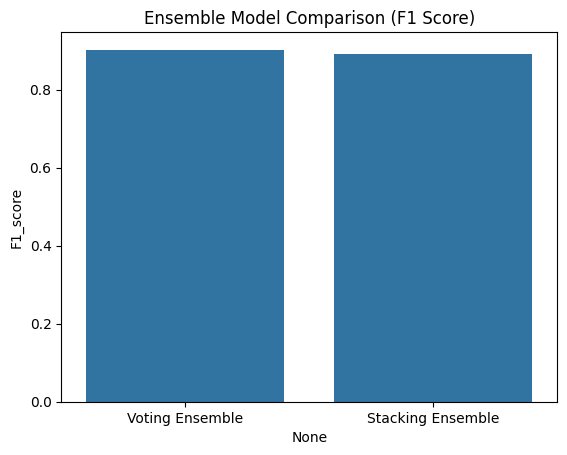

In [125]:
sns.barplot(data=metrics_df, x=metrics_df.index, y="F1_score")
plt.title("Ensemble Model Comparison (F1 Score)")
plt.show()


In [126]:
os.makedirs("models", exist_ok=True)
joblib.dump(voting_clf, "models/best_voting_ensemble.joblib")
joblib.dump(stacking_clf, "models/best_stacking_ensemble.joblib")
print("\nEnsembles completed and models saved")


Ensembles completed and models saved
